# Anomaly Detection

The following tutorial contains Python examples for detecting anomalies (outliers) from data. You should refer to Chapters 9 of the "Introduction to Data Mining" book to understand some of the concepts introduced in this tutorial. The notebook can be downloaded from http://www.cse.msu.edu/~ptan/dmbook/tutorials/tutorial9/tutorial9.ipynb.

Anomaly detection is the task of identifying instances whose characteristics differ significantly from the rest of the data. In this tutorial, we will provide examples of applying different anomaly detection techniques using Python and its library packages. 

Read the step-by-step instructions below carefully. To execute the code, click on the corresponding cell and press the SHIFT-ENTER keys simultaneously.

## 9.1 Using Parametric Models 

This approach assumes that the majority of the data instances are governed by some well-known probability distribution, e.g., Binomial or Gaussian distribution. Anomalies can then detected by seeking for observations that do not fit the overall distribution of the data. 

In this example, our goal is to detect anomalous changes in the daily closing prices of various stocks. The input data *stocks.csv* contains the historical closing prices of stocks for 3 large corporations (Microsoft, Ford Motor Company, and Bank of America). 

In [4]:
import pandas as pd

stocks = pd.read_csv('stocks.csv', header='infer')
stocks.index = stocks['Date']
stocks = stocks.drop(['Date'], axis=1)
stocks.head()

,MSFT,F,BAC
Date,,,
1/3/2007,29.860001,7.51,53.330002
1/4/2007,29.809999,7.70,53.669998
1/5/2007,29.639999,7.62,53.240002
1/8/2007,29.930000,7.73,53.450001
1/9/2007,29.959999,7.79,53.500000


We can compute the percentage of changes in the daily closing price of each stock as follows:
\begin{equation}
\Delta(t) = 100 \times \frac{x_t - x_{t-1}}{x_{t-1}} 
\end{equation}

where $x_t$ denotes the price of a stock on day $t$ and $x_{t-1}$ denotes the price on its previous day, $t-1$.

In [5]:
import numpy as np

N, d = stocks.shape
delta = pd.DataFrame(100*np.divide(stocks.iloc[1:, :].values-stocks.iloc[:N-1, :].values, stocks.iloc[:N-1, :].values),
                     columns=stocks.columns, index=stocks.iloc[1:].index)
delta.head()

,MSFT,F,BAC
Date,,,
1/4/2007,-0.167455,2.529960,0.637532
1/5/2007,-0.570278,-1.038961,-0.801185
1/8/2007,0.978411,1.443570,0.394438
1/9/2007,0.100231,0.776197,0.093543
1/10/2007,-1.001332,-0.770218,0.149536


We can plot the distribution of the percentage daily changes in stock price. 

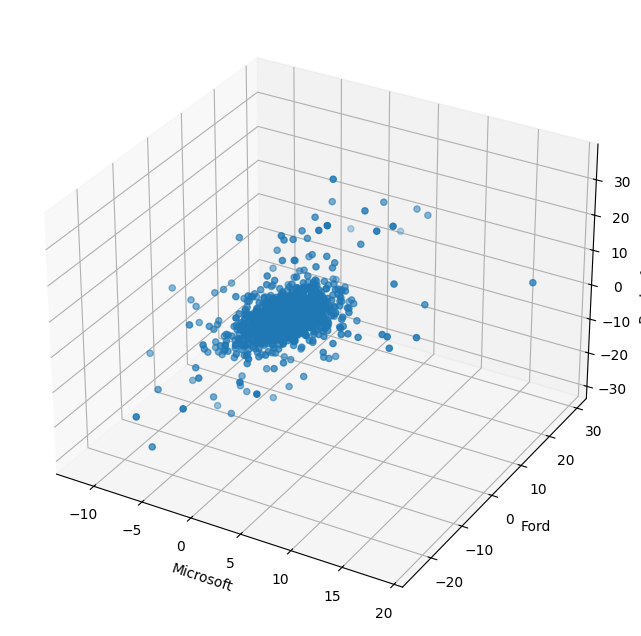

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(delta.MSFT, delta.F, delta.BAC)
ax.set_xlabel('Microsoft')
ax.set_ylabel('Ford')
ax.set_zlabel('Bank of America')

plt.show()

Assuming the data follows a multivariate Gaussian distribution, we can compute the mean and covariance matrix of the 3-dimensional data as follows

In [8]:
meanValue = delta.mean()
covValue = delta.cov()
print(meanValue)
print(covValue)

MSFT    0.045003
F       0.061374
BAC     0.033351
dtype: float64
          MSFT         F        BAC
MSFT  3.191674  2.136351   2.788870
F     2.136351  8.524944   4.997405
BAC   2.788870  4.997405  13.770761


To determine the anomalous trading days, we can compute the Mahalanobis distance between the percentage of price change on each day against the mean percentage of price change.
\begin{equation}
\textrm{Mahalanobis}(x) = (x - \bar{x}) \Sigma^{-1}(x - \bar{x})^T
\end{equation}
where $x$ is assumed to be a row vector.

See Equation 9.4 in Section 9.3.1 for more information about using Mahalanobis distance for detecting anomalies in multivariate Gaussian distribution.

C:\Users\antra\AppData\Local\Temp\ipykernel_16120\1065966557.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X[:, i] = X[:, i] - meanValue[i]


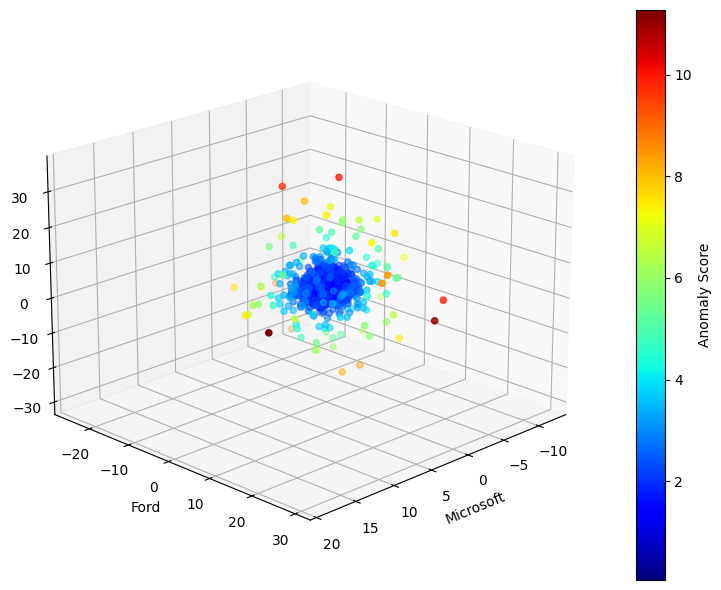

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

# Convert DataFrame to numpy array
X = delta.values
S = covValue.values

# Subtract mean from each column
for i in range(3):
    X[:, i] = X[:, i] - meanValue[i]


def mahalanobis(row):
    return np.sqrt(np.matmul(np.matmul(row, inv(S)), row.T))


# Apply Mahalanobis distance calculation to each row
anomaly_score = np.apply_along_axis(mahalanobis, axis=1, arr=X)

# Create the 3D scatter plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color based on anomaly score
scatter = ax.scatter(delta.MSFT, delta.F, delta.BAC,
                     c=anomaly_score, cmap='jet')

ax.set_xlabel('Microsoft')
ax.set_ylabel('Ford')
ax.set_zlabel('Bank of America')

# Add a color bar
fig.colorbar(scatter, label='Anomaly Score')

# Adjust the view angle for better visibility
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

The top-2 anomalies are shown as a brown point in the figure above. The highest anomaly corresponds to the day in which the prices for all 3 stocks increase significantly whereas the second highest anomaly corresponds  to the day in which all 3 stocks suffer a large percentage drop in their closing prices. We can examine the dates associated with the top-2 highest anomaly scores as follows. 

In [14]:
anom = pd.DataFrame(anomaly_score, index=delta.index,
                    columns=['Anomaly score'])


result = pd.concat((delta, anom), axis=1)


result.nlargest(2, 'Anomaly score')

,MSFT,F,BAC,Anomaly score
Date,,,,
10/13/2008,18.559648,20.039128,9.166457,11.269084
11/26/2008,2.456248,29.456698,4.223406,11.016388


Note that the sharp drop in the stock prices on October 7, 2008 coincide with the beginning of the global financial crisis (https://en.wikipedia.org/wiki/Global_financial_crisis_in_October_2008) while the increase in the stock prices on April 9, 2009. 

Text(0, 0.5, 'Percent Change')

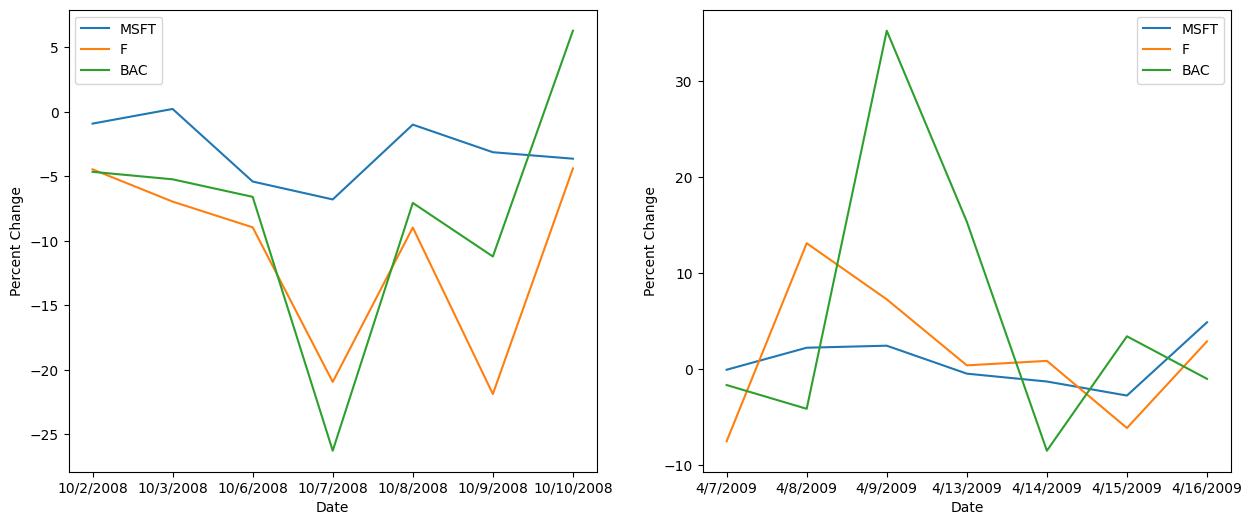

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ts = delta[440:447]
ts.plot.line(ax=ax1)
ax1.set_xticks(range(7))
ax1.set_xticklabels(ts.index)
ax1.set_ylabel('Percent Change')

ts = delta[568:575]
ts.plot.line(ax=ax2)
ax2.set_xticks(range(7))
ax2.set_xticklabels(ts.index)
ax2.set_ylabel('Percent Change')

## 9.2 Using Distance-based Approach

This is a model-free anomaly detection approach as it does not require constructing an explicit model of the normal class to determine the anomaly score of data instances. The example code shown below employs the k-nearest neighbor approach to calculate anomaly score. Specifically, a normal instance is expected to have a small distance to its k-th nearest neighbor whereas an anomaly is likely to have a large distance to its k-th nearest neighbor. In the example below, we apply the distance-based approach with k=5 to identify the anomalous trading days from the stock market data described in the previous section.

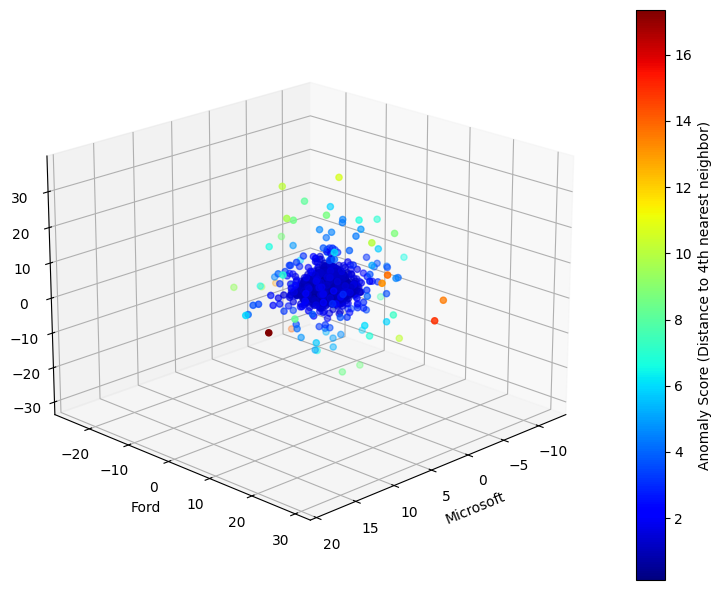

In [17]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Number of nearest neighbors
knn = 5

# Convert DataFrame to numpy array
delta_array = delta.values

# Fit NearestNeighbors and find the distances
nbrs = NearestNeighbors(n_neighbors=knn, metric='euclidean').fit(delta_array)
distances, indices = nbrs.kneighbors(delta_array)

# Calculate anomaly score (distance to the kth nearest neighbor)
anomaly_score = distances[:, knn-1]

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color based on anomaly score
scatter = ax.scatter(delta.MSFT, delta.F, delta.BAC,
                     c=anomaly_score, cmap='jet')

ax.set_xlabel('Microsoft')
ax.set_ylabel('Ford')
ax.set_zlabel('Bank of America')

# Add color bar
cbar = fig.colorbar(scatter)
cbar.set_label('Anomaly Score (Distance to 4th nearest neighbor)')

# Adjust the view for better visibility
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

The results are slightly different than the one shown in Section 9.1 since we have used Euclidean distance (instead of Mahalanobis distance) to detect the anomalies. We can examine the dates associated with the top-5 highest anomaly scores as follows. 

In [18]:
anom = pd.DataFrame(anomaly_score, index=delta.index,
                    columns=['Anomaly score'])


result = pd.concat((delta, anom), axis=1)


result.nlargest(5, 'Anomaly score')

,MSFT,F,BAC,Anomaly score
Date,,,,
10/13/2008,18.559648,20.039128,9.166457,17.346825
11/26/2008,2.456248,29.456698,4.223406,14.926018
10/7/2008,-6.789282,-20.928583,-26.259300,13.955351
12/8/2008,5.692284,24.203332,17.027017,13.728360
11/28/2008,-1.362724,25.054905,5.280972,13.518226


Text(0, 0.5, 'Percent Change')

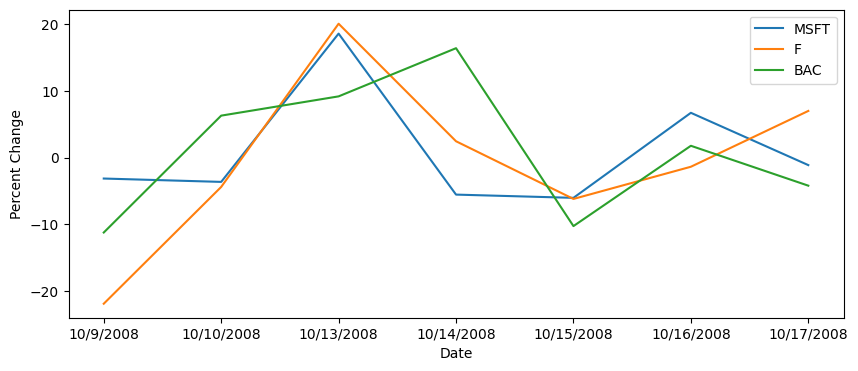

In [19]:
fig = plt.figure(figsize=(10, 4))

ax = fig.add_subplot(111)
ts = delta[445:452]
ts.plot.line(ax=ax)
ax.set_xticks(range(7))
ax.set_xticklabels(ts.index)
ax.set_ylabel('Percent Change')

## 9.3 Summary

This tutorial illustrates examples applying an anomaly detection approach to a multivariate time series data. We consider two approaches, one based on a parametric statistical approach using multivariate Gaussian while the other is a nonparametric distance-based approach using k-nearest neighbor.